# Express, Manage, and Execute async/sync workflows with RADICAL-AsyncFlow.
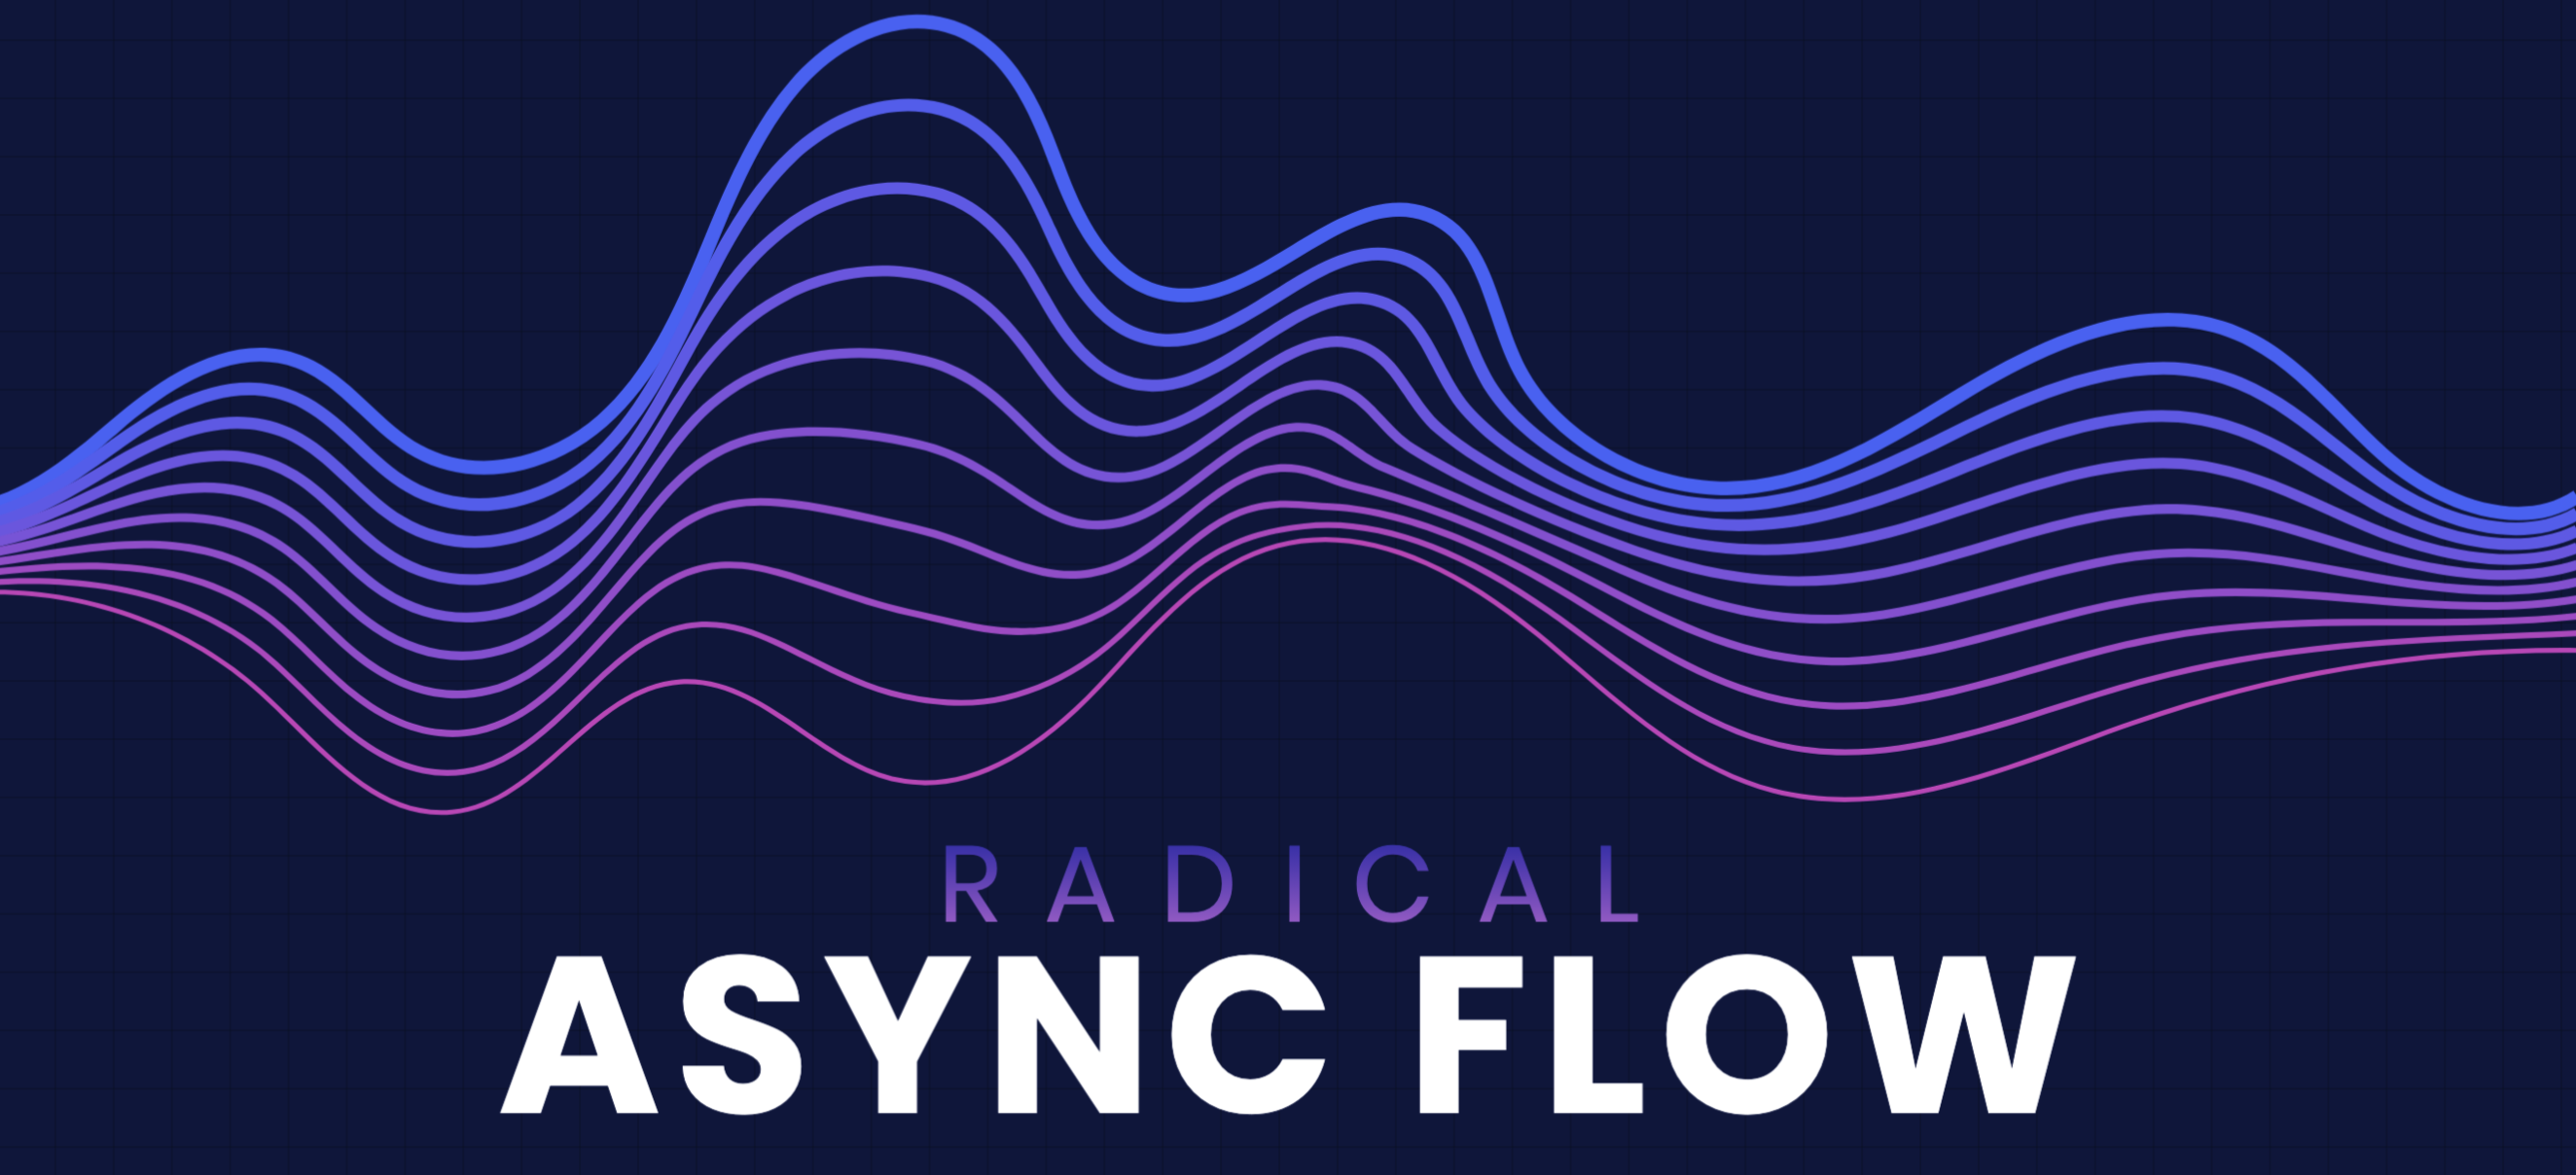
RADICAL AsyncFlow is a fast asynchronous scripting library built on top of asyncio for complex asynchronous workflows on HPC, clusters, and local machines. It supports pluggable execution backends with intuitive task dependencies and workflow composition. Currently, AsyncFlow supports the following execution backends:


**The goal of this notebook is to:**

1. Showcase the ability to use asynchronous execution within Jupyter.
2. Show the performance when submitting 5 workflows asynchronously.
3. Highlight the support for different execution backends. 

> **Note:** Asynchronous execution does not necessarily imply full parallelism. True parallelism ultimately depends on the capabilities and configuration of the execution backend you are using.

> **Tip:** Remember that asynchronous does not necessarily implies that all of the workflows will start/finish at the same time.

## Asynchronous programming with `AsyncFlow`
The goal here is to show that the power of asynchronous programming that `asyncflow` enables 4 blocking `workflows` to run asynchronously. We will demonstrate the case where we have N independent blocking workflows, and we will program them with Radical.AsyncFlow in `async`  appraoch and deliver the results based on their completion order.

### Asynchronous Workflows


We will submit 5 blocking workflows programmed in `Async` approach and wait for their completion.

```
                                         ┌──────────────┐
                                         │    Start     │
                                         └──────────────┘
                                                │
                                                ▼
                                  ┌─────────────────────────────┐
                                  │ Launch N workflows async    │
                                  └─────────────────────────────┘
                                            │ │ │ │ │
                                            ▼ ▼ ▼ ▼ ▼
                                  ┌─────────────────────────────┐
                                  │ Each workflow:              │
                                  │  task1 + task2 → task3 → ✓  │
                                  └─────────────────────────────┘
                                            │ │ │ │ │
                                            ▼ ▼ ▼ ▼ ▼
                                  ┌─────────────────────────────┐
                                  │ Wait for all to finish      │
                                  └─────────────────────────────┘
                                            │ │ │ │ │
                                            ▼ ▼ ▼ ▼ ▼
                                  ┌─────────────────────────────┐
                                  │   Print total time          │
                                  └─────────────────────────────┘
                                                │
                                                ▼
                                  ┌─────────────────────────────┐
                                  │   Shutdown WorkflowEngine   │
                                  └─────────────────────────────┘
```

In [ ]:
import time
import asyncio
from radical.asyncflow import ConcurrentExecutionBackend
from concurrent.futures import ThreadPoolExecutor
from radical.asyncflow import WorkflowEngine

backend = await ConcurrentExecutionBackend(ThreadPoolExecutor())

async with WorkflowEngine(backend=backend) as flow:
    @flow.function_task
    async def task1(*args):
        return time.time()

    @flow.function_task
    async def task2(*args):
        return time.time()

    @flow.function_task
    async def task3(*args):
        return time.time()

    async def run_wf(wf_id):

        print(f'Starting workflow {wf_id} at {time.time()}')
        t3 = task3(task1(), task2())
        await t3 # Blocking operation so the entire workflow will block
        print(f'Workflow {wf_id} completed at {time.time()}')

    start_time = time.time()
    await asyncio.gather(*[run_wf(i) for i in range(5)])
    end_time = time.time()

    print(f'\nTotal time running asynchronously is: {end_time - start_time}')

## Different Execution Backend? Couldn't be any easier. Just change 1 line of code
By design, `AsyncFlow` focuses on the concept of `separation of concern`, which enforces that the execution backend should be entirely isolated from the `Asynchronous` programming layer and follows the `PnP` design choice. In this way, the user can plug and unplug any execution backend they prefer by just replacing a few lines of code.

### Using `RadicalExecutionBackend` instead of `ConcurrentExecutionBackend` to execute `Async` workflows

We will show how we can use `Radical.Pilot` to execute `blocking` workflows like the previus example.

In [ ]:
import time
import asyncio
from radical.asyncflow import RadicalExecutionBackend
from radical.asyncflow import WorkflowEngine

backend = await RadicalExecutionBackend({'resource': 'local.localhost'})

#                  vs

# backend = await ConcurrentExecutionBackend(ThreadPoolExecutor())

async with WorkflowEngine(backend=backend) as flow:
    @flow.executable_task
    async def task1(*args):
        return "/bin/date"

    @flow.executable_task
    async def task2(*args):
        return "/bin/date"

    @flow.executable_task
    async def task3(*args):
        return "/bin/date"

    async def run_wf(wf_id):

        print(f'Starting workflow {wf_id} at {time.time()}')
        t3 = task3(task1(), task2())
        await t3 # Blocking operation so the entire workflow will block
        print(f'Workflow {wf_id} completed at {time.time()}')

    start_time = time.time()
    await asyncio.gather(*[run_wf(i) for i in range(5)])
    end_time = time.time()

    print(f'\nTotal time running asynchronously is: {end_time - start_time}')

